In [246]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle

In [247]:
def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

In [248]:
# meta porta corridoio lavagne fine: 0870
# porta anti incendio corridoio per andare verso il corridoio delle lavagne: 0538
# spigolo per girare a sinistra verso tavoloni 1366

# 632 centro angolo lavagne

In [249]:
positions = pd.read_csv('../data/povo-god/positions.csv')
predictions = pd.read_csv('../data/povo-god/predictions.csv')
targets = pd.read_csv('../data/povo-god/targets.csv')
A = '0538.png'
B = '0870.png'
C = '1366.png'

In [250]:
px = 630
a = positions[positions.image == '0632.png'][['x','y','z']].squeeze()
b = positions[positions.image == '0891.png'][['x','y','z']].squeeze()
unit_measure = np.sqrt(np.sum((a - b)**2))
unit_measure

4.22608635945641

In [251]:
colmap_crs = positions[positions.image.isin([A, B, C])][['x','y','z']].values.T
cadatastral_crs = np.array([
    [690, 430, 1715],
    [280, 895, 1050],
    [0, 0, 0]
])
colmap_crs = colmap_crs / unit_measure * px

In [252]:
# RA + t = B
R, t = rigid_transform_3D(colmap_crs, cadatastral_crs)
R, t

(array([[ 0.09043424,  0.21994528, -0.97131134],
        [-0.99584784,  0.00975923, -0.09050882],
        [-0.01042773,  0.97546339,  0.2199146 ]]),
 array([[1080.31885417],
        [ 652.52917988],
        [  -1.84188703]]))

In [253]:
#points = positions[positions.image.isin(['0554.png', '0001.png', '0999.png'])][['x','y','z']].values.T
points = positions[['x','y','z']].values.T
points = points / unit_measure * px

predictions = predictions[['tx','ty','tz']].values.T
predictions = predictions / unit_measure * px

targets = targets[['tx','ty','tz']].values.T
targets = targets / unit_measure * px

D = (np.matmul(R, points) + t).T
F = (np.matmul(R, predictions) + t).T
G = (np.matmul(R, targets) + t).T

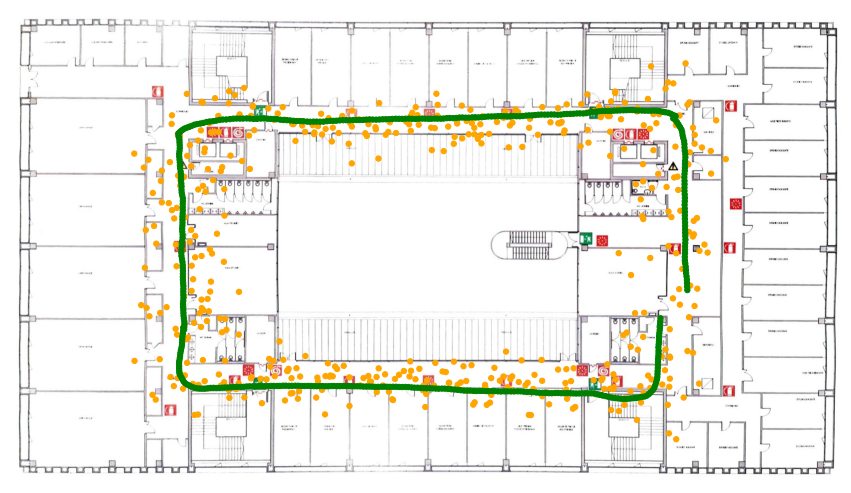

In [256]:
img = plt.imread('../camera-pose-estimation/model/static/cadatastral_plan_all.jpg')
fig, ax = plt.subplots(1, figsize=(15,15))
ax.set_aspect('equal')
ax.axis('off')

ax.imshow(img)
#for p in D: 
#    circ = Circle((p[0]*1, p[1]*0.95+15), 7)
#    ax.add_patch(circ)
for p in F: 
    circ = Circle((p[0], p[1]), 7, color='orange')
    ax.add_patch(circ)
for p in G: 
    circ = Circle((p[0], p[1]), 7, color='green')
    ax.add_patch(circ)
#for p in cadatastral_crs.T: 
    #circ = Circle((p[0], p[1]), 15, color='red')
    #ax.add_patch(circ)
    
#for a,b in zip(F, G):
    #ax.plot([a[0],b[0]],[a[1],b[1]], color='blue')

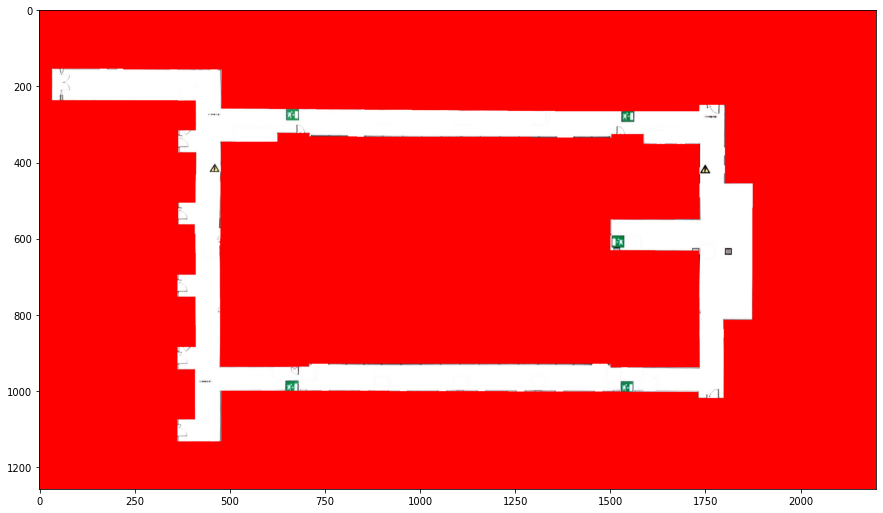

In [89]:
img = plt.imread('../camera-pose-estimation/model/static/cadatastral_plan_all_walkable.jpg')
fig, ax = plt.subplots(1, figsize=(15,15))

ax.imshow(img)

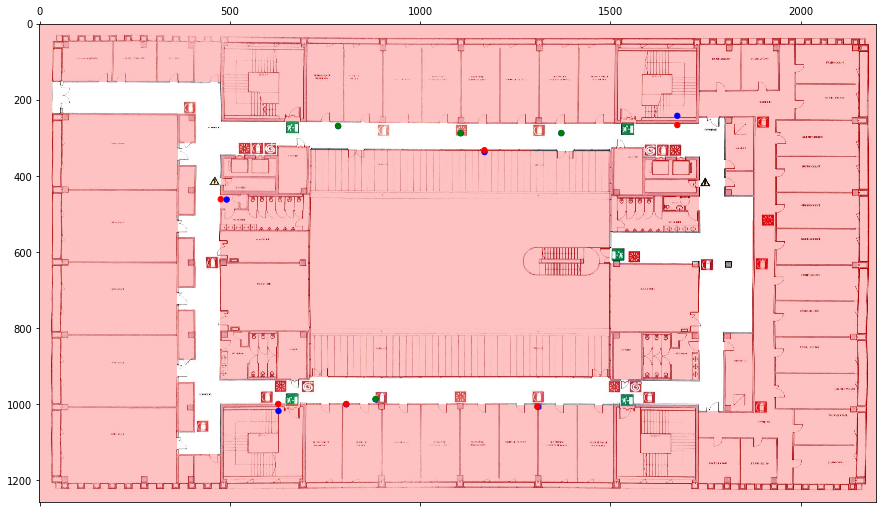

In [235]:
img=cv2.imread('../camera-pose-estimation/model/static/cadatastral_plan_all_walkable.jpg')
alpha = plt.imread('../camera-pose-estimation/model/static/cadatastral_plan_all_alpha.jpg')

img_hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

lower_red = np.array([0,50,50])
upper_red = np.array([10,255,255])
mask0 = cv2.inRange(img_hsv, lower_red, upper_red)
is_walkable = mask0!=255
fig, ax = plt.subplots(1, figsize=(15,15))


predetto = F[300]
ax.matshow(alpha)

def adjust_prediction(prediction):
    x, y = prediction.astype(int)[:2]
    if is_walkable[y, x]:
        return Circle((x, y), 7, color='green')
    min_dist, min_row, min_col = (np.Inf,0,0)
    for i_row, row in enumerate(is_walkable):
        for i_col, cell in enumerate(row):
            if cell:
                dist = np.sqrt((y - i_row)**2+(x - i_col)**2)
                if dist < min_dist:
                    min_dist = dist
                    min_row = i_row
                    min_col = i_col
    return Circle((min_col, min_row), 7, color='red')

for p in F[:10]: 
    circ2 = Circle((p[0], p[1]), 7, color='blue')
    ax.add_patch(circ2)
    circ = adjust_prediction(p)
    ax.add_patch(circ)
    #ax.plot([circ[0], circ2[0]], [circ[1], circ2[1]])